In [3]:
import os 
import numpy as np 
import pickle
from tqdm import tqdm 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import copy
from sklearn.utils import resample, shuffle

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler



In [4]:
# functions 
###### helper functions ####### 
def pkl_read(file_to_read, write_dir):
  this = pickle.load(open(os.path.join(write_dir,file_to_read), "rb"))
  # print(this)
  return this

def pkl_write(file_to_write, values_to_dump, write_dir):
  os.chdir(write_dir)
  with open(os.path.join(write_dir,file_to_write), 'wb') as pickle_file:
      pickle.dump(values_to_dump, pickle_file)

def getdata_day(data,id,data_day):
  if id == 1:
    # var_name = data[0:data_day[id]+1,:,:]
    var_name = data[0:data_day[id],:,:]
  else:
    day_idx = np.where(np.array(list(data_day))== id)[0].astype(int) - 1
    #print(day_idx[0])
    prev_day_id = list(data_day)[day_idx[0]]
    #print(prev_day_id)
    var_name = data[data_day[prev_day_id]:data_day[id],:,:]
  return var_name

def gettarget_day(target_direction, id, day):
    if id == 1: 
      target = target_direction[:day[id]]
    else:
      day_idx = np.where(np.array(list(day))== id)[0].astype(int) - 1
      #print(day_idx[0])
      prev_day_id = list(day)[day_idx[0]]
      target = target_direction[day[prev_day_id]:day[id]] 
    return target

def get_numtrials_perday(datasize_day):
    '''
    datasize_day: dictionary with key as day and value as end trial index for that day . Comes from getdata_day()
    '''
    num_trials_perday = np.zeros(len(datasize_day))
    num_trials_perday[0] = np.array(list(datasize_day.values()))[0]
    num_trials_perday[1:] = np.diff(np.array(list(datasize_day.values())))
    # print(num_trials_perday)
    return num_trials_perday

def trial_concatenate_data(data):
    '''
    data is on shape n_trials x n_units x n_bins 
    '''
    n,u,t = data.shape
    new_arr = np.transpose(data, (0,2,1))
    new_arr = new_arr.reshape(n*t, u)
    # print(new_arr.shape)
    return new_arr 

###### PR analysis functions #########

def calculate_PR(data, normalize_pr = True, normalize_data = 'zscore', sqrt_transform = False ):
    '''
    Args: 
    data (2D Numpy array): Neural data in format (n_timepoints, n_units)
    '''
    # n_t, n_u = data.shape
    if  normalize_data == 'zscore': 
        scaler_ = StandardScaler()
        standardized_data = scaler_.fit_transform(data)
        data = standardized_data
    if normalize_data  == 'demean':
        scaler_ = StandardScaler(with_mean = True, with_std = False)
        standardized_data = scaler_.fit_transform(data)
        data = standardized_data
#         print(scaler_.mean_)
        
    if sqrt_transform:
        data = np.sqrt(data + 0.375)  # see Kihlberg, 1972; 0.386 could also be a good value
            
    C_unit = np.cov(data.T)
#     print(C_unit.shape)
    eig_val, eig_vec = np.linalg.eig(C_unit)
    PR = (np.sum(eig_val))**2/ np.sum(eig_val**2)
    return (PR - 1) / (data.shape[1] - 1) if normalize_pr else PR

def hypothesis_testing(data1, data2, sqrt_transform=False, normalize_data = 'zscore',
                       nb_permutations=int(1e4), use_normalized_PR=False):
    """
    Null hypothesis : no difference in the mean PR between the two datasets `data1` and `data2`
    Alternative : PR(data2) > PR(data1)  (direction is important).

    Parameters:
    ----------
    data1 : 2D np.ndarray of integers with shape (n_time_bins, n_units)
        Design matrix for first dataset. Each row contains the spike counts of the units in the corresponding time bin.
    data2: 2D np.ndarray of integers with shape (n_time_bins, n_units)
        Design matrix for second dataset.
    sqrt_transform : bool (default: False)
        Whether to transform the count data before computing PR_norm.
    nb_perturbations : int
        Number of permutations of day index.
    use_normalized_PR : bool (default: False)
        Whether to compute the normalized PR or the participation ratio itself

    Returns:
    -------
    p-value : float
    """
    n_samples1, n_units1 = data1.shape
    n_samples2, n_units2 = data2.shape
    assert n_units1 == n_units2, "`data1` and `data2` must have the same number of units"
    
    late_pr =  calculate_PR(data2, normalize_pr= use_normalized_PR,normalize_data=normalize_data, sqrt_transform=sqrt_transform)
    print('late_pr: ',late_pr)
    early_pr =  calculate_PR(data1,  normalize_pr= use_normalized_PR,normalize_data=normalize_data, sqrt_transform=sqrt_transform)
    print('early_pr: ',early_pr)
    test_statistic = late_pr - early_pr # direction is important
    print('delta_pr: ',test_statistic)

    # Compute bootstrapped delta_PR estimates
    bootstrapped_delta_PRs = np.empty(shape=nb_permutations)

    null_PRs = np.empty(shape=nb_permutations)
    data_cat = np.vstack((data1, data2))

    for i in range(nb_permutations):
        # true delta PR distribution
        bootstrap_data1 = resample(data1)
        bootstrap_data2 = resample(data2)
        bootstrapped_pr1 = calculate_PR(bootstrap_data1, normalize_pr=use_normalized_PR,
                                        normalize_data=normalize_data, sqrt_transform=sqrt_transform)
        bootstrapped_pr2 = calculate_PR(bootstrap_data2, normalize_pr=use_normalized_PR,
                                        normalize_data=normalize_data, sqrt_transform=sqrt_transform)
        bootstrapped_delta_PRs[i] = bootstrapped_pr2 - bootstrapped_pr1

        # Null delta PR distribution
        data_cat_shuffle = shuffle(data_cat)
        data1_permut, data2_permut = data_cat_shuffle[:n_samples1], data_cat_shuffle[n_samples1:]
        null_PRs[i] = calculate_PR(data2_permut, normalize_pr= use_normalized_PR,normalize_data=normalize_data, sqrt_transform=sqrt_transform) - calculate_PR(data1_permut, normalize_pr= use_normalized_PR,normalize_data=normalize_data, sqrt_transform=sqrt_transform)

    # P-value
    p_value = np.sum(null_PRs > test_statistic) / nb_permutations
  
    return p_value, test_statistic, null_PRs, bootstrapped_delta_PRs

###### Statistics functions ######## 

def compute_ci(data, alpha = 0.95):
    import scipy.stats as st
    ci = st.t.interval( df=len(data)-1, loc=np.mean(data), scale=st.sem(data), confidence=alpha)
    return ci # returns actual values of lower and upper CI 

def compute_moe(data, alpha = 0.95):
    import scipy.stats as st
    moe = st.t.ppf((1 + alpha) / 2., len(data)-1) * st.sem(data) 
    return moe # returns margin of error for lower and upper CI - can be used for errorbars


In [5]:
neural_recordings = pkl_read('neural_data.pkl', './example_data/') # Shape: n_tr x n_units x n_timebins; top 16 units are readouts 
target_direction = pkl_read('target_labels.pkl', './example_data/')
datasize_day = pkl_read('trial_day_label.pkl', './example_data/')

days = [2,3,4,5,6] # just for example. In the paper, we considered all days that had a minimum of 25 trials of successful reaches per target direction, minimum 200 trials in total.  
n_readouts = 20

5it [00:00, 39.49it/s][00:00<?, ?it/s]
5it [00:00, 39.13it/s][00:00<00:01,  7.77it/s]
5it [00:00, 41.62it/s][00:00<00:01,  7.71it/s]
5it [00:00, 45.49it/s][00:00<00:00,  7.92it/s]
5it [00:00, 43.17it/s][00:00<00:00,  8.29it/s]
5it [00:00, 42.91it/s][00:00<00:00,  8.36it/s]
5it [00:00, 40.60it/s][00:00<00:00,  8.38it/s]
5it [00:00, 42.94it/s][00:00<00:00,  8.23it/s]
5it [00:00, 44.87it/s][00:00<00:00,  8.30it/s]
5it [00:00, 44.20it/s][00:01<00:00,  8.45it/s]
100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


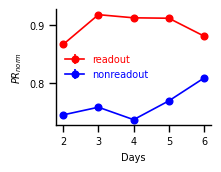

In [6]:
# error bars for Global PR from 10000 draws on all trials
n_bs = 10 #10000 
normalize_data = 'zscore'

g_normPR_all_bs = np.zeros((n_bs, len(days)))
g_normPR_r_bs = np.zeros((n_bs, len(days)))
g_normPR_nr_bs = np.zeros((n_bs, len(days)))

# l_normPR_all_bs = np.zeros((n_bs, len(days), 8))
# l_normPR_r_bs = np.zeros((n_bs, len(days), 8))
# l_normPR_nr_bs = np.zeros((n_bs, len(days), 8))


for idraw in tqdm(range(n_bs)): 

      for id, iday in tqdm(enumerate(days)): 
            # per day
            data_all = getdata_day(neural_recordings,iday, datasize_day )


            data = trial_concatenate_data(data_all)
            # print(data.shape)

            g_normPR_all_bs[idraw, id] = calculate_PR(data, normalize_pr= True, normalize_data=normalize_data, sqrt_transform=False)
            g_normPR_r_bs[idraw, id] = calculate_PR(data[:, :n_readouts], normalize_pr= True, normalize_data=normalize_data, sqrt_transform=False)
            g_normPR_nr_bs[idraw, id] = calculate_PR(data[:,n_readouts:], normalize_pr= True, normalize_data=normalize_data, sqrt_transform=False)

            ## this is to compute PR per target direction
            # target = gettarget_day(target_direction, iday, datasize_day)
            # print(np.unique(target))
            # for it in np.unique(target).astype(int):
            #       it_idx = np.where(target[idx] == it)[0]
            #       data_it = data_idx[it_idx,:,:]
            #       data_it = trial_concatenate_data(data_it)
            #       # print(data.shape, it)

            #       l_normPR_all_bs[idraw, id, it-1] = calculate_PR(data_it, normalize_pr= True, normalize_data=normalize_data, sqrt_transform=False)
            #       l_normPR_r_bs[idraw, id, it-1] = calculate_PR(data_it[:, :direct_idx_2.shape[0]], normalize_pr= True, normalize_data=normalize_data, sqrt_transform=False)
            #       l_normPR_nr_bs[idraw, id, it-1] = calculate_PR(data_it[:, direct_idx_2.shape[0]:], normalize_pr= True, normalize_data=normalize_data, sqrt_transform=False)

# Compute statistics from bootstrap
ci_all = np.zeros((g_normPR_all_bs.shape[1],2))
ci_r = np.zeros((g_normPR_r_bs.shape[1],2))
ci_nr = np.zeros((g_normPR_nr_bs.shape[1],2))

for i in range(g_normPR_r_bs.shape[1]): 
    ci_all[i,:] = compute_moe(g_normPR_all_bs[:,i])
    ci_r[i,:] = compute_moe(g_normPR_r_bs[:,i])
    ci_nr[i,:] = compute_moe(g_normPR_nr_bs[:,i])

# Save results in a dataframe
df_prnorm = pd.DataFrame() 
df_prnorm['days'] = days
df_prnorm['pr_all_mean'] = np.mean(g_normPR_all_bs, axis = 0)
df_prnorm['pr_r_mean'] = np.mean(g_normPR_r_bs, axis = 0)
df_prnorm['pr_nr_mean'] = np.mean(g_normPR_nr_bs, axis = 0)

df_prnorm['pr_all_ci_l'] =  ci_all[:,0] # this is the actual lower bound CI PR value
df_prnorm['pr_r_ci_l'] = ci_r[:,0]
df_prnorm['pr_nr_ci_l'] =  ci_nr[:,0]

df_prnorm['pr_all_ci_u'] = ci_all[:,1] 
df_prnorm['pr_r_ci_u'] = ci_r[:,1] 
df_prnorm['pr_nr_ci_u'] = ci_nr[:,1] 

# plot results - Similar to Figure 2A, 2B in Paper 
sns.set_context('paper')
plt.figure(figsize = (2,1.5))
plt.errorbar(np.array(df_prnorm['days']),df_prnorm['pr_r_mean'], yerr = np.vstack((np.array(df_prnorm['pr_r_ci_l']), np.array(df_prnorm['pr_r_ci_u']))), color = 'r', label = 'readout', marker = 'o')
plt.errorbar(np.array(df_prnorm['days']),df_prnorm['pr_nr_mean'], yerr = np.vstack((np.array(df_prnorm['pr_nr_ci_l']), np.array(df_prnorm['pr_nr_ci_u']))), color = 'b',  label = 'nonreadout', marker = 'o')
# plt.plot(np.array(df_prnorm['days']),df_prnorm['pr_r_mean'],color = 'r', label = 'readout')
# plt.plot(np.array(df_prnorm['days']),df_prnorm['pr_nr_mean'],color = 'b',  label = 'nonreadout')
# plt.fill_between(np.array(df_prnorm['days']),df_prnorm['pr_r_ci_l'], df_prnorm['pr_r_ci_u'], color = 'r', alpha = 0.4)
# plt.fill_between(np.array(df_prnorm['days']),df_prnorm['pr_nr_ci_l'], df_prnorm['pr_nr_ci_u'], color = 'b', alpha = 0.4)

plt.legend( frameon = False, labelcolor = 'linecolor', fontsize = 7)
plt.xticks(days, fontsize = 7)
plt.yticks(fontsize = 7)
# plt.title('PCA dimensionality')
plt.xlabel('Days', fontsize = 7)
plt.ylabel('$PR_{norm}$', fontsize = 7)
sns.despine()


In [7]:
# Computing delta_PR distributions 
early_day = days[1]
late_day = days[-1]
 
early_data_trials = getdata_day(neural_recordings, early_day, datasize_day)
early_data_trials = np.squeeze(early_data_trials[:,:n_readouts,:])
early_data = trial_concatenate_data(early_data_trials)

late_data_trials = getdata_day(neural_recordings, late_day, datasize_day)
late_data_trials = np.squeeze(late_data_trials[:,:n_readouts,:]) 
late_data = trial_concatenate_data(late_data_trials)

p, test_stat,  null_prs, delta_prs = hypothesis_testing(late_data, early_data, nb_permutations=10000, normalize_data= 'zscore', use_normalized_PR = True)
# delta_prs is the distribution of delta_pr obtained through bootstrapping. 


late_pr:  0.9183442304054305
early_pr:  0.8811330931631323
delta_pr:  0.03721113724229819
